# Introduction

This project is an exercise in using the sqlconnect3 module. Below is our prompt from Dataquest:

## Prompt 1:

"The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA."

## Prompt 2:

"Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others."

## Prompt 3

"Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, you should group these customers as 'Other' in your analysis. You'll want to force 'Other' to the bottom of your results."

## Prompt 4

"The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

purchase a whole album
purchase a collection of one or more individual tracks.
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue."

First, let's start by importing our needed libraries.

In [3]:
# import our needed libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# run the below jupyter magic to show matplotlib graphs in-line
%matplotlib inline

Let's also make our lives easier by creating a few functions that do the following:
- run_query(): takes a SQL query as an argument and returns a pandas dataframe of that query.
- run_command(): takes a SQL command as an argument and executes it using the sqlite module.
- show_tables(): calls the run_query() function to return a list of all tables and views in the database.

After creating these functions, we'll then run the show_tables() function to see all of the tables and views that we are working with.

In [4]:
# create the run_query function using chinook.db as the database
def run_query(q):
  with sqlite3.connect('chinook.db') as conn:
    return pd.read_sql(q, conn)

# create the run_command function
def run_command(c):
  with sqlite3.connect('chinook.db') as conn:
    conn.isolation_level = None
    conn.execute(c)
    
# create the show_tables function
def show_tables():
    # define the query to get all of the views and tables
    q = """SELECT
             name,
             type
           FROM sqlite_master
           WHERE type IN ("table","view");"""
    # use the run_query function to run the query
    return run_query(q)

# run the show_tables function
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Now that we have written our functions, let's look at solving prompt 1 above.

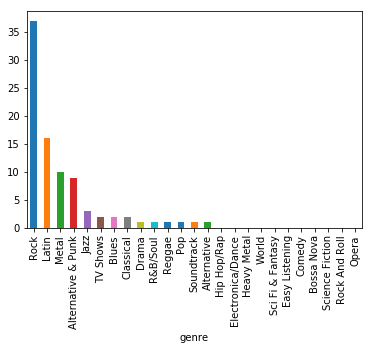

In [5]:
# Write a query that returns each genre, with the number of tracks sold in the USA in absolute numbers and percentages
q = """
       SELECT
         g.name as genre,
         COUNT(t.track_id) as tracks_sold,
         (COUNT(t.track_id) * 100 / 
         (SELECT
           COUNT(DISTINCT track_id)
          FROM track)) as tracks_sold_perc_of_total
       FROM track t
       INNER JOIN genre g ON t.genre_id = g.genre_id
       GROUP BY g.name
       ORDER BY COUNT(t.track_id) DESC
    """

# run the query
tracks_sold_by_genre = run_query(q)

# display the results
tracks_sold_by_genre.plot(x='genre',y='tracks_sold_perc_of_total',kind='bar',legend=None)

# Prompt 1 Analysis

From looking at the above graph, and looking at our choices below, it appears that Punk, Blues, and Pop are the most popular of the four genres. As a result, we should sell albums from the following artists:
- Red Tone
- Slim Jim Bites
- Red Tone

Now that we have answered prompt 1, let's look at prompt 2 mentioned in the Introduction.

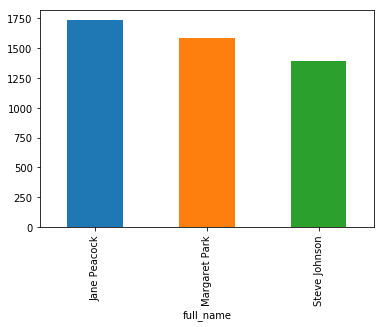

In [11]:
# Write a query that orders sales support reps who work with customers with the most purchases
# NOTE: Turns out there is a total column in Invoice. I used unit_price * quantity can be used in its place not knowing total was there
q = """
        SELECT 
          emp.employee_id,
          emp.first_name || ' ' || emp.last_name as full_name,
          emp.title,
          emp.hire_date,
          emp.birthdate,
          emp.reports_to, 
          sum(total_sold_sub.total_sold) as total_sold_by_customers_under_rep
        FROM employee emp
        INNER JOIN customer cust ON emp.employee_id = cust.support_rep_id
        INNER JOIN invoice inv ON cust.customer_id = inv.customer_id
        INNER JOIN
          (SELECT
            invoice_id,
            SUM(unit_price * quantity) as total_sold
          FROM invoice_line
          GROUP BY invoice_id) total_sold_sub ON inv.invoice_id = total_sold_sub.invoice_id
        GROUP BY emp.employee_id
    """

# run the query
sales_support_reps_sales = run_query(q)

# plot the results
sales_support_reps_sales.plot(x='full_name',y='total_sold_by_customers_under_rep',kind='bar',legend=None)

In [7]:
# check the hire_date
sales_support_reps_sales

,employee_id,full_name,title,hire_date,birthdate,reports_to,total_sold_by_customers_under_rep
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1973-08-29 00:00:00,2,1731.51
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1947-09-19 00:00:00,2,1584.00
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1965-03-03 00:00:00,2,1393.92


# Prompt 2 Analysis

From looking at the above graph, it looks like Jane Peacock is winning in the total sold department. That said, it also looks like Jane started before Margaret and Steve, so Jane could have gotten a leg up as a result in getting sales before Margaret and Steve joined the company.

Now that we have answered prompt 2, let's look at prompt 3 mentioned in the Introduction.

In [69]:
# Write a query that creates the 'Other' category and provides the following:
## Total customers by country
## Total sales by country
## Avg sales per customer by country
## Avg order value by country
q = """
        SELECT 
          other_grouping.country,
          COUNT(DISTINCT cust.customer_id) as customer_count_by_country,
          SUM(inv.total) as total_sales_by_country,
          sum(inv.total) / count(DISTINCT cust.customer_id) as avg_sales_per_customer_in_country,
          sum(inv.total) / count(DISTINCT inv.invoice_id) as avg_order_value_by_country
        FROM
          customer cust
          INNER JOIN invoice inv ON cust.customer_id = inv.customer_id
          INNER JOIN
            (SELECT 
              country as country_old,
              COUNT(DISTINCT customer_id) as customer_count,
              CASE WHEN COUNT(DISTINCT customer_id) = 1 THEN 'Other' ELSE country END AS country
             FROM customer
             GROUP BY country) other_grouping ON cust.country = other_grouping.country_old
        GROUP BY other_grouping.country
        ORDER BY CASE WHEN other_grouping.country = 'Other' THEN 0 ELSE 1 END DESC, total_sales_by_country DESC
    """

# save the query to a variable
country_stats = run_query(q)

# show the dataframe
country_stats

,country,customer_count_by_country,total_sales_by_country,avg_sales_per_customer_in_country,avg_order_value_by_country
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


Now that we have our data aggregated, let's now create some visualizations and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns. Since we are comparing values, it makes sense to create four separate bar graphs for each of the items below:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Also, since we're looking at which countries to advertise in, we are not going to include the countries in the 'Other' group since these countries have only one customer and would spread our advertising thin from Argentina to Ireland (both in these groups and varying languages in between).

Now, let's create those visualizations.

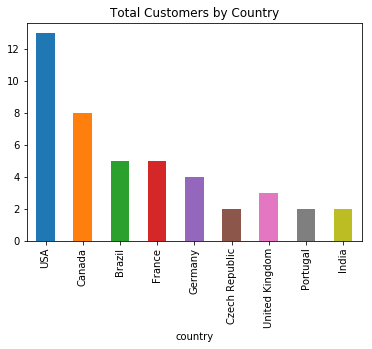

In [77]:
# First, let's exclude the 'Other' category as mentioned above
country_stats_no_other = country_stats[country_stats["country"]!='Other']

# Also, set the index as the Country
country_stats_no_other.set_index('country',inplace=True)

# Total Number of Customers by Country
country_stats_no_other["customer_count_by_country"].plot(kind='bar',title='Total Customers by Country')

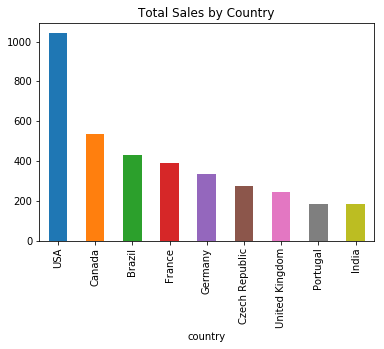

In [78]:
# Total Sales by Country
country_stats_no_other["total_sales_by_country"].plot(kind='bar',title='Total Sales by Country')

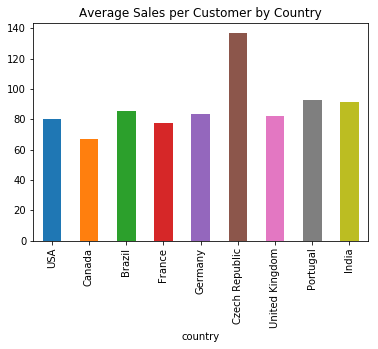

In [81]:
# Average value of sales per customer
country_stats_no_other["avg_sales_per_customer_in_country"].plot(kind='bar',title='Average Sales per Customer by Country')

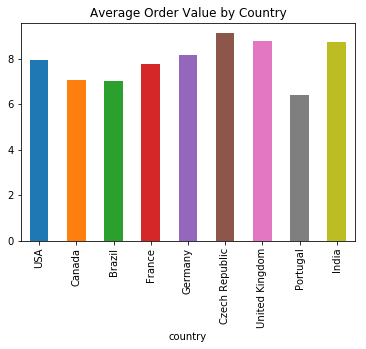

In [82]:
# Average order value
country_stats_no_other["avg_order_value_by_country"].plot(kind='bar',title='Average Order Value by Country')

# Prompt 3 Analysis:

Based on the above visualizations, it looks like the two folks from the Czech Republic are heavy music lovers with the highest average sales of around $140 for each customer. As a result, the Czech Republic would be a good candidate for a marketing campaign to get more customers.

With Prompt 3 under our belts, let's now look at Prompt 4.

In [188]:
# # it looks like I have the number of full album purchases. I just then need to label  
# Write a query that checks whether a purchase is an album purchase or individual track purchase
q = """ SELECT 
          inv.invoice_id, 
          CASE 
            WHEN full_album_inv.invoice_id is NOT NULL Then 'Album Purchase' 
            ELSE 'Singles Purchase' END as album_or_singles_purchase
        FROM invoice inv
        LEFT JOIN
        (SELECT DISTINCT
          COUNT(DISTINCT tr.track_id) as track_count,
          tr.album_id,
          inv.invoice_id
        FROM invoice inv
        INNER JOIN invoice_line inv_line ON inv.invoice_id = inv_line.invoice_id
        INNER JOIN track tr ON inv_line.track_id = tr.track_id
        INNER JOIN
          (SELECT 
            COUNT(DISTINCT track_id) as track_count,
            album_id
          FROM
            track
          GROUP BY album_id
          HAVING COUNT(DISTINCT track_id) > 2) album_set ON tr.album_id = album_set.album_id
        GROUP BY tr.album_id, inv.invoice_id
        
        INTERSECT

        SELECT DISTINCT
          album_set.track_count,
          tr.album_id,
          inv.invoice_id
        FROM track tr
        INNER JOIN
          (SELECT 
            COUNT(DISTINCT track_id) as track_count,
            album_id
          FROM
            track
          GROUP BY album_id
          HAVING COUNT(DISTINCT track_id) > 2) album_set ON tr.album_id = album_set.album_id
        LEFT JOIN invoice_line inv_line ON tr.track_id = inv_line.track_id
        LEFT JOIN invoice inv ON inv_line.invoice_id = inv.invoice_id) full_album_inv ON inv.invoice_id = full_album_inv.invoice_id
    """

# run the query
run_query(q)

,invoice_id,album_or_singles_purchase
0,16,Singles Purchase
1,77,Singles Purchase
2,149,Singles Purchase
3,153,Album Purchase
4,182,Singles Purchase
5,184,Singles Purchase
6,223,Album Purchase
7,270,Singles Purchase
8,296,Album Purchase
9,442,Singles Purchase


In [186]:
# # it looks like I have the number of full album purchases. I just then need to label  
# Write a query that checks whether a purchase is an album purchase or individual track purchase
q = """ SELECT 
          COUNT(distinct full_album_inv.invoice_id) as total_album_purchases,
          COUNT(distinct full_album_inv.invoice_id) * 100 / count(distinct inv.invoice_id)   as percentage_album_purchases
        FROM invoice inv
        LEFT JOIN
        (SELECT DISTINCT
          COUNT(DISTINCT tr.track_id) as track_count,
          tr.album_id,
          inv.invoice_id
        FROM invoice inv
        INNER JOIN invoice_line inv_line ON inv.invoice_id = inv_line.invoice_id
        INNER JOIN track tr ON inv_line.track_id = tr.track_id
        INNER JOIN
          (SELECT 
            COUNT(DISTINCT track_id) as track_count,
            album_id
          FROM
            track
          GROUP BY album_id
          HAVING COUNT(DISTINCT track_id) > 2) album_set ON tr.album_id = album_set.album_id
        GROUP BY tr.album_id, inv.invoice_id
        
        INTERSECT

        SELECT DISTINCT
          album_set.track_count,
          tr.album_id,
          inv.invoice_id
        FROM track tr
        INNER JOIN
          (SELECT 
            COUNT(DISTINCT track_id) as track_count,
            album_id
          FROM
            track
          GROUP BY album_id
          HAVING COUNT(DISTINCT track_id) > 2) album_set ON tr.album_id = album_set.album_id
        LEFT JOIN invoice_line inv_line ON tr.track_id = inv_line.track_id
        LEFT JOIN invoice inv ON inv_line.invoice_id = inv.invoice_id) full_album_inv ON inv.invoice_id = full_album_inv.invoice_id
    """

# run the query
run_query(q)

,total_album_purchases,percentage_album_purchases
0,111,18


# Prompt 4 Analysis

Since it looks like only 18% of purchases are complete album sales, it would be wise for Chinook to not completely give up their selling of singles.

# Conclusion

That's all for now! Thank you for reading.